Data from the experiment on 2021/07/14: this file puts data in channels * cycles * z * y * x

# Preprocessing

In [1]:
import heapq
import os
import sys
import numpy as np
import pandas as pd
# import tifffile as tif
# import h5py
from skimage import io, img_as_float32
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.filters import threshold_yen
# import IPython.display
# import PIL
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append("../bardensr")
import bardensr
import bardensr.plotting

In [2]:
n_channels = 2
n_cycles = 5

with open('./data/registered20210714_sg2NEB.npy', 'rb') as f:
    X = np.load(f)

# img = tif.imread('./data/crisprmap20210506/amp-ch1-cycle0.tiff')
# img_size = img.shape[:2]

# X = np.zeros((n_channels*n_cycles, 1, *img_size))
# k = 0
# for i in range(n_channels):
#     for j in range(n_cycles):
#         fn = f'./data/crisprmap20210506/amp-ch{i+1}-cycle{j}.tiff'
#         print(fn)
#         img = tif.imread(fn)
#         X[k, 0, :, :] = img[:, :, 1]  # using layer 1 out of layers 0-3
#         k = k+1

In [3]:
X.shape

(10, 1, 2048, 1280)

In [4]:
# for i in range(X.shape[0]):
#     plt.figure(dpi=250)
#     plt.imshow(X[i, 0,])

## Check how many pixels are roughly in one amplicon

In [5]:
# img = tif.imread('./data/crisprmap20210506/amp-ch1-cycle2.tiff')
# plt.figure(dpi=100)
# plt.imshow(img[80:100, 80:100, 1])
# plt.axis('image')
# # im.view()

This shows if the windows for local maxima is 3 by 3 pixels, they should be right for catching one amplicon

## Remove border artifact and get X only within the range of the slide - segmentation images must be set to the same range when overlaying

In [6]:
up = 0
down = 1800
left = 10
right = 1150

Xcenter = X[:, :, up:down, left:right] # range is selected based on observation of images

In [7]:
# for i in range(Xcenter.shape[0]):
#     plt.figure(dpi=250)
#     plt.imshow(Xcenter[i, 0,])

# Codebook

The most important is to make sure the codebook and the images are of the same order

In [8]:
# !! currently the first value shows nan and hard code it to be 1; needs a better fix
codebook = np.genfromtxt('./data/CRISPRmap_pilot_codebook_default.csv', filling_values=1, dtype=np.int, delimiter=",")
codebook

array([[1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0]])

In [9]:
# codebook = csv.reshape((10, 2, 5)).T.astype(bool)
# codebook

In [10]:
codebook.shape

(10, 10)

The order of the codebook matches the order of the image stack.

## Background subtraction and normalization

In [11]:
Xcenter.shape

(10, 1, 1800, 1140)

In [12]:
# Different from how bardensr did it (use these functions for now because they are tested)
Xnorm = bardensr.preprocessing.background_subtraction(Xcenter, [0,10,10])
Xnorm = bardensr.preprocessing.minmax(Xnorm)

In [13]:
Xnorm.shape

(10, 1, 1800, 1140)

In [14]:
# for i in range(Xnorm.shape[0]):
#     plt.figure(dpi=250)
#     plt.imshow(Xnorm[i, 0,])

## Distribution

In [15]:
# # create the histogram
# for i in range(Xnorm.shape[0]):
#     histogram, bin_edges = np.histogram(Xnorm[i, 0], bins=256, range=(0, 1))

#     # configure and draw the histogram figure
#     plt.figure()
# #     plt.title("Grayscale Histogram")
#     plt.xlabel("grayscale value")
#     plt.ylabel("pixels")

#     plt.semilogy(bin_edges[0:-1], histogram)  # <- or here

#     plt.xlim([0.0, 1.0])  # <- named arguments do not work here
#     plt.show()

## Thresholding

In [16]:
Xnorm.shape

(10, 1, 1800, 1140)

In [17]:
Xnorm[0, 0,].shape

(1800, 1140)

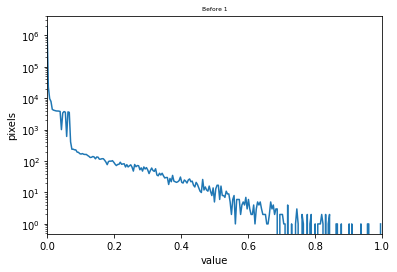

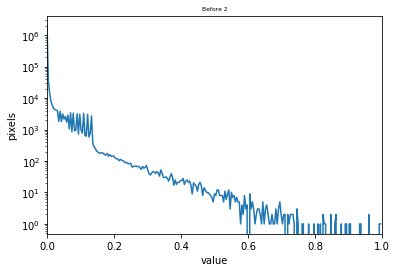

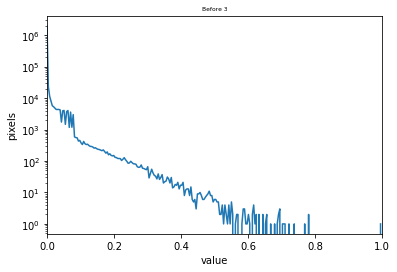

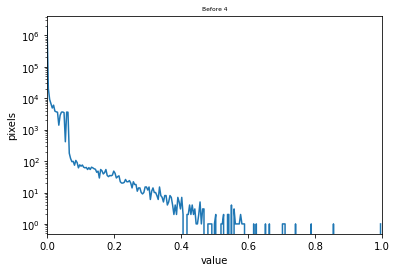

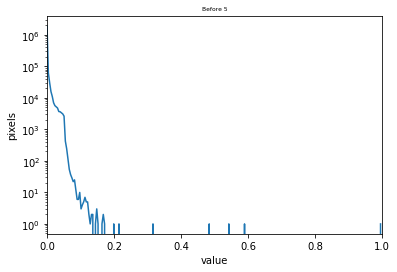

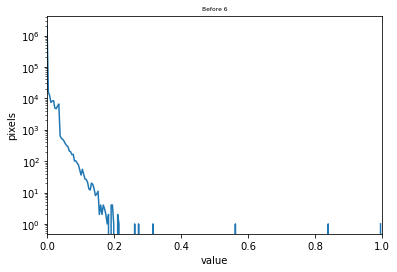

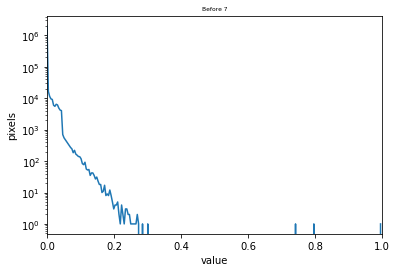

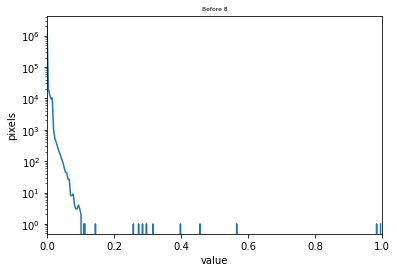

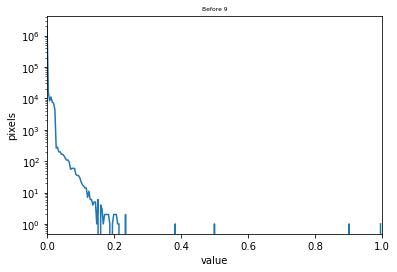

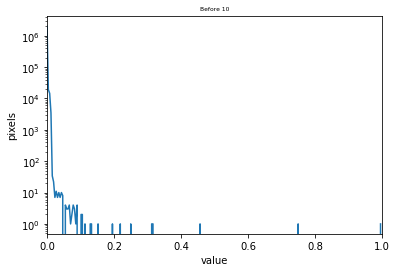

In [18]:
# Before
for i in range(Xnorm.shape[0]):
    histogram, bin_edges = np.histogram(Xnorm[i, 0, ], bins=256, range=(0, 1))

    # configure and draw the histogram figure
    plt.figure()
    plt.title(f"Before {i+1}", fontsize=6)
    plt.xlabel("value")
    plt.ylabel("pixels")

    plt.semilogy(bin_edges[0:-1], histogram)  # <- or here

    plt.xlim([0.0, 1.0])  # <- named arguments do not work here
    plt.show()

In [19]:
upper = [0.9, 0.9, 0.8, 0.6, 0.14, 0.2, 0.3, 0.1, 0.2, 0.015]
# lower = [0.2, 0.16, 0.13, 0.15, 0.16, 0.16, 0.16, 0.13, 0.15, 0.15]
Xthresh = Xnorm.copy()
for i in range(Xthresh.shape[0]):
    single = Xthresh[i, 0,]
#     single[single < lower[i]] = 0
    single[single > upper[i]] = upper[i]
    Xthresh[i, 0] = single
    
Xthresh = bardensr.preprocessing.minmax(Xthresh)

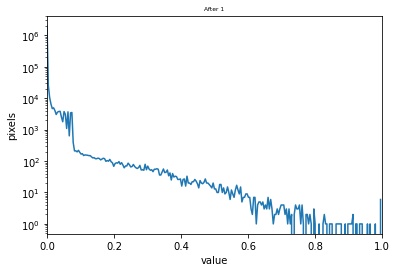

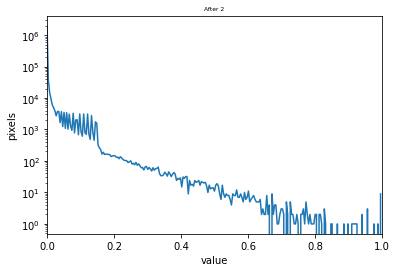

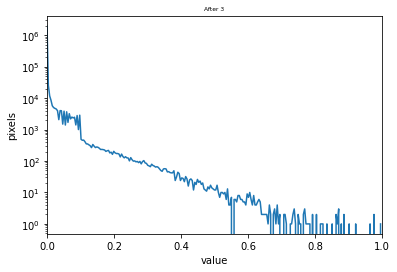

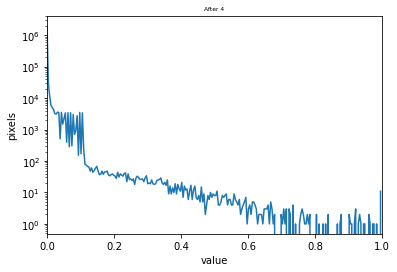

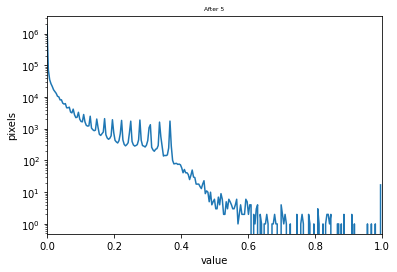

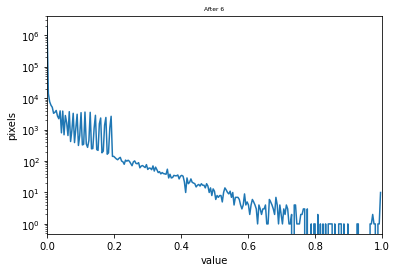

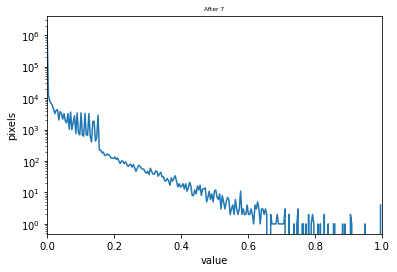

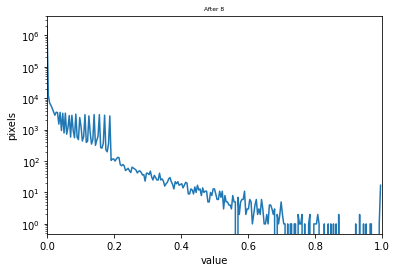

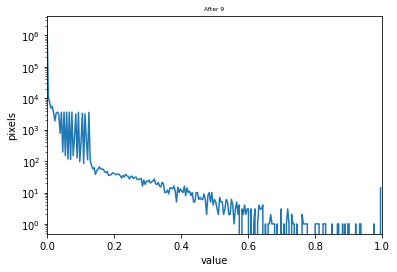

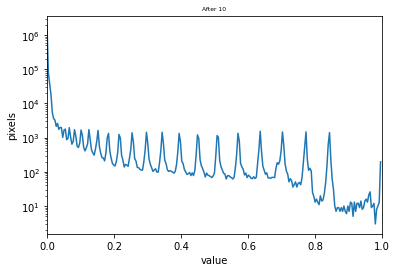

In [20]:
# After
for i in range(Xthresh.shape[0]):
    histogram, bin_edges = np.histogram(Xthresh[i, 0, ], bins=256, range=(0, 1))

    # configure and draw the histogram figure
    plt.figure()
    plt.title(f"After {i+1}", fontsize=6)
    plt.xlabel("value")
    plt.ylabel("pixels")

    plt.semilogy(bin_edges[0:-1], histogram)  # <- or here

    plt.xlim([0.0, 1.0])  # <- named arguments do not work here
    plt.show()

In [21]:
# for i in range(Xthresh.shape[0]):
#     plt.figure(dpi=400)
#     plt.imshow(Xthresh[i, 0])
#     plt.title(i+1)

In [22]:
# residual = 0.05  # tested through the spot method and the cell method should be less sensitive 
# Xthresh = Xnorm.copy()
# Xthresh[Xthresh < residual] = 0

In [23]:
# # Using threshold Yen on Xnorm
# Xthresh = np.zeros(Xnorm.shape)
# for i in range(Xnorm.shape[0]):
#     image = Xnorm[i, 0, ]
#     thresh = threshold_yen(image)
#     binary = image > thresh
#     Xthresh[i, 0, ] = binary
    
#     plt.figure(dpi=500)
#     fig, axes = plt.subplots(ncols=2, figsize=(18, 18))
#     ax = axes.ravel()

#     ax[0].imshow(image)
#     ax[0].set_title('Before')

#     ax[1].imshow(binary)
#     ax[1].set_title('After')

#     for a in ax:
#         a.axis('off')

#     plt.show()

In [24]:
# for i in range(Xthresh.shape[0]):
#     histogram, bin_edges = np.histogram(Xthresh[i, 0, ], bins=256, range=(0, 1))

#     # configure and draw the histogram figure
#     plt.figure()
#     plt.title(i+1)
#     plt.xlabel("value")
#     plt.ylabel("pixels")

#     plt.semilogy(bin_edges[0:-1], histogram)  # <- or here

#     plt.xlim([0.0, 1.0])  # <- named arguments do not work here
#     plt.show()

<Figure size 3000x2000 with 0 Axes>

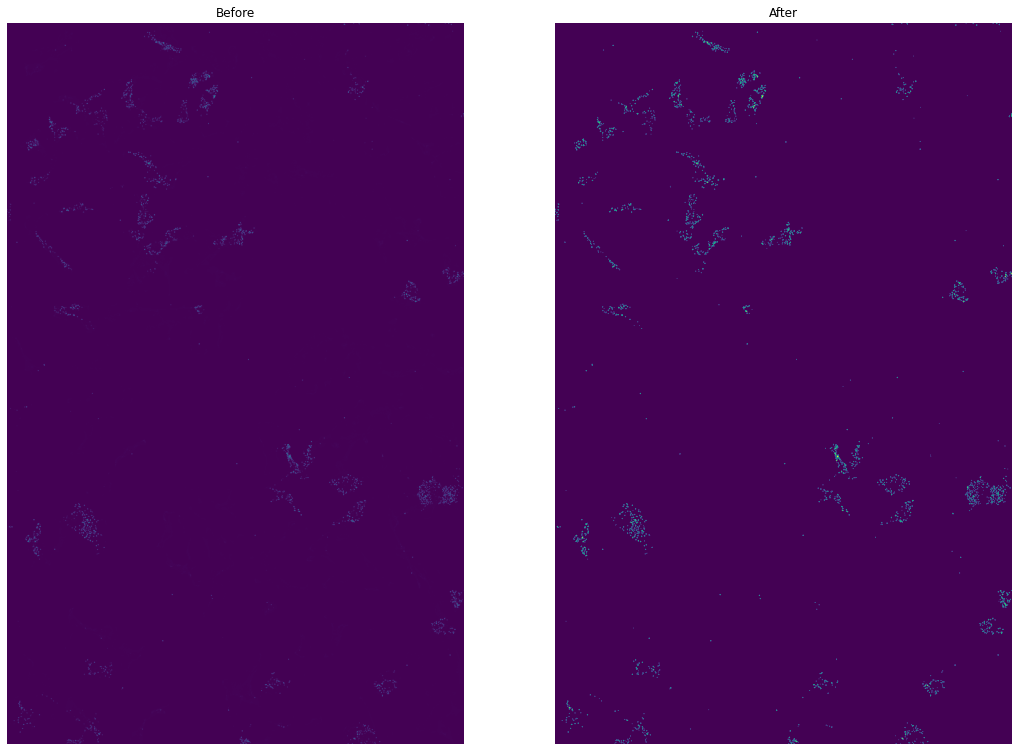

<Figure size 3000x2000 with 0 Axes>

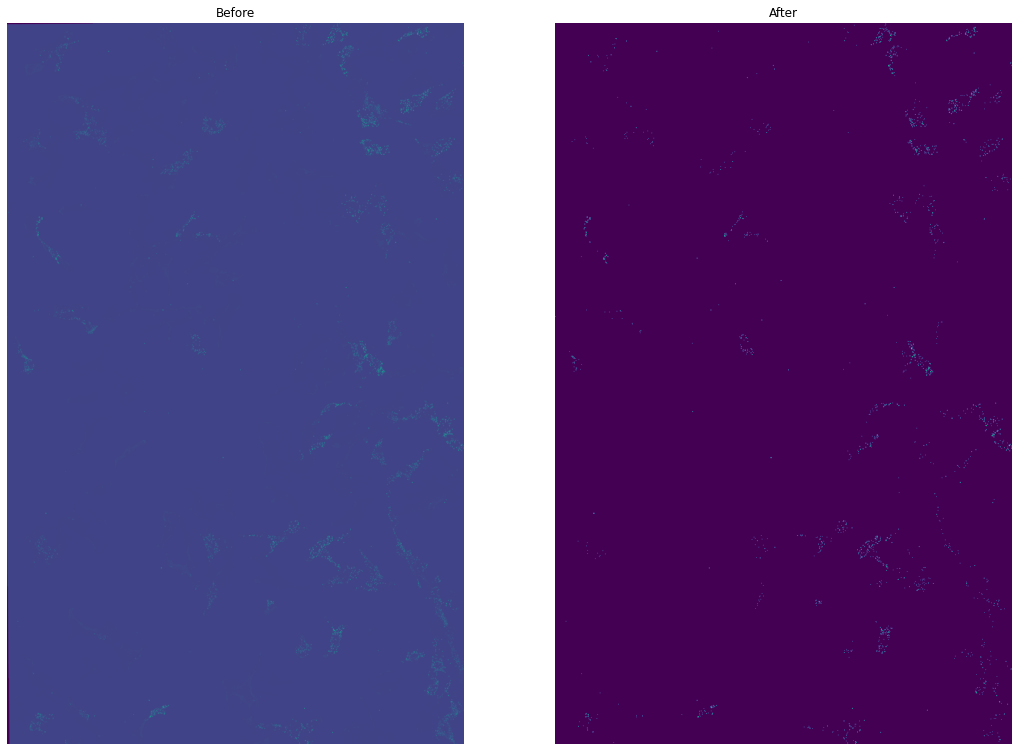

<Figure size 3000x2000 with 0 Axes>

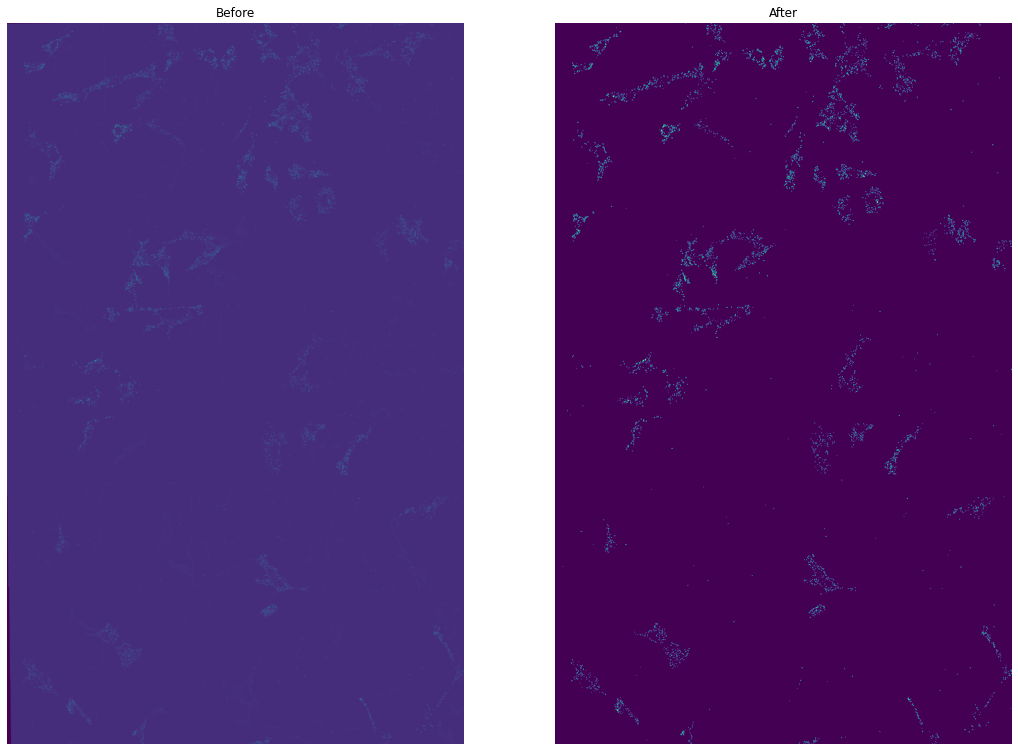

<Figure size 3000x2000 with 0 Axes>

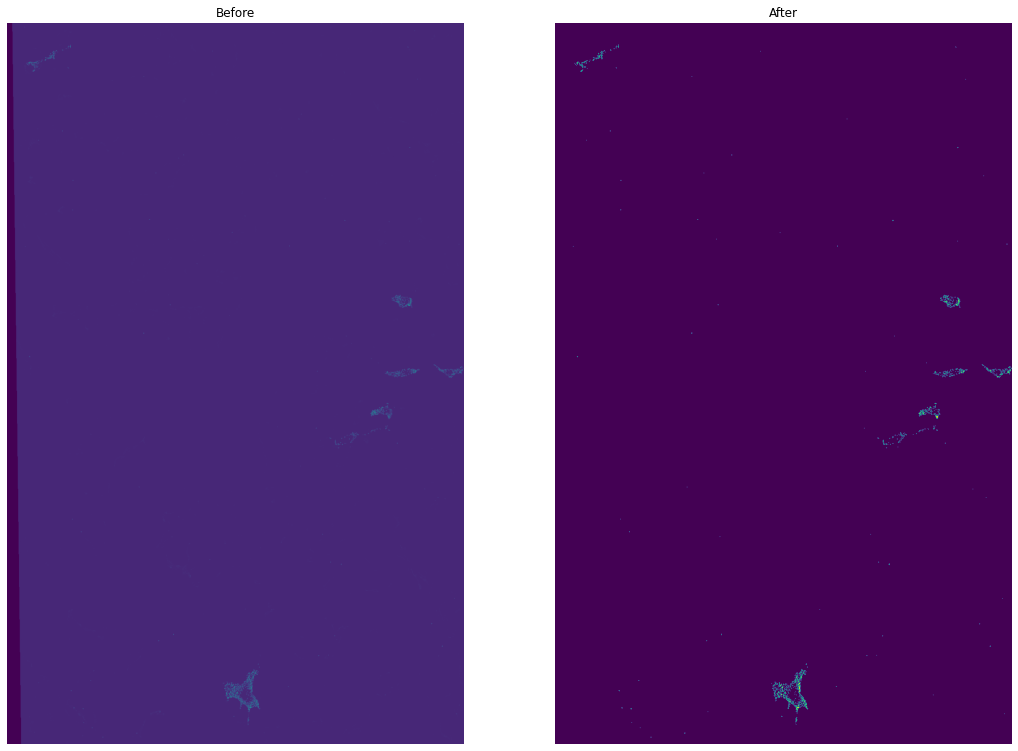

<Figure size 3000x2000 with 0 Axes>

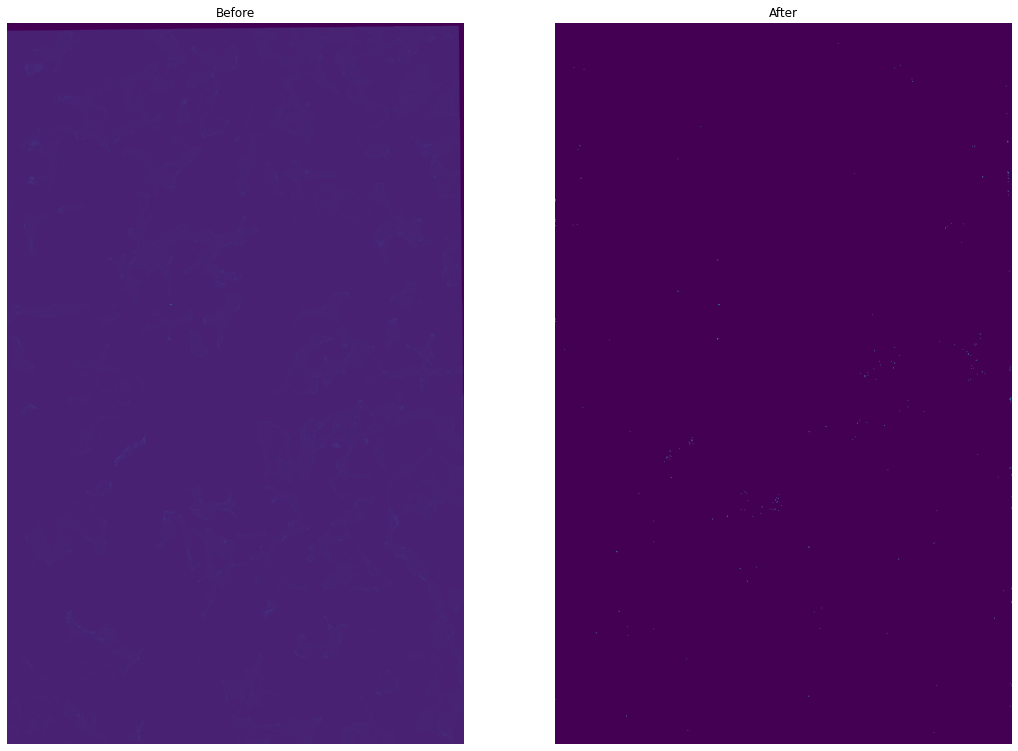

<Figure size 3000x2000 with 0 Axes>

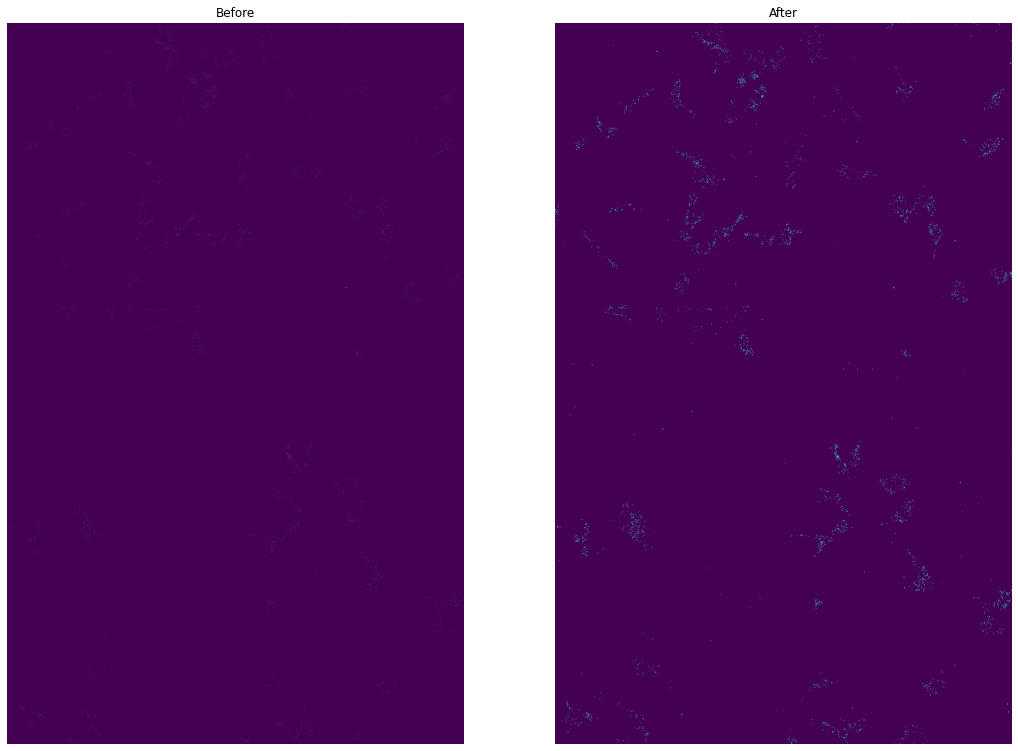

<Figure size 3000x2000 with 0 Axes>

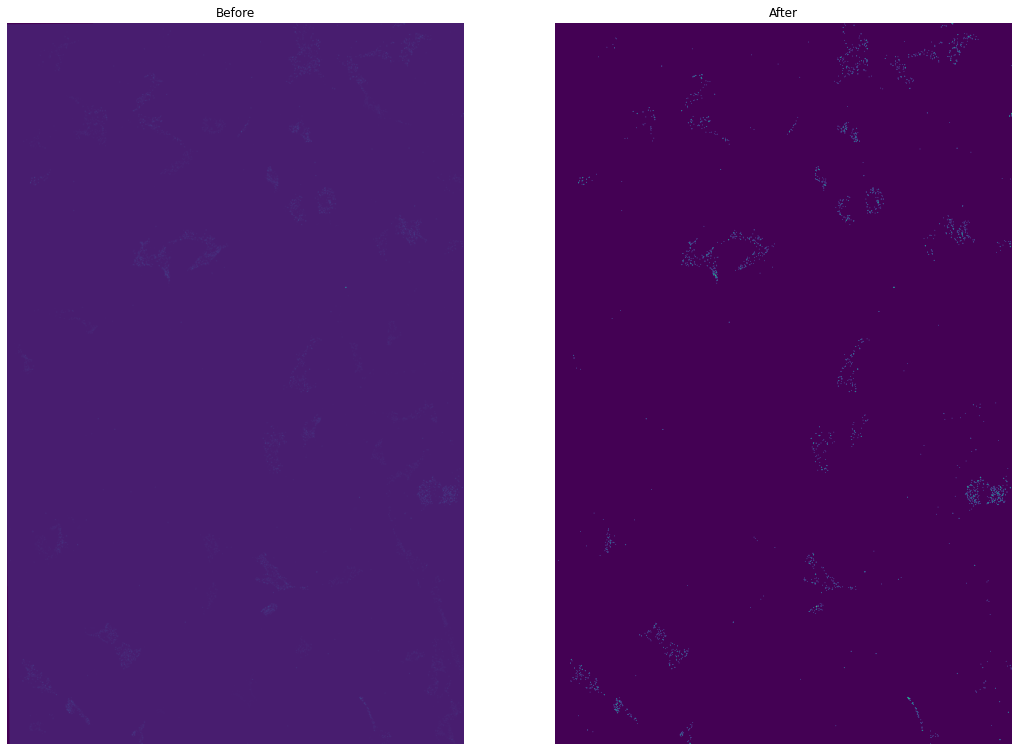

<Figure size 3000x2000 with 0 Axes>

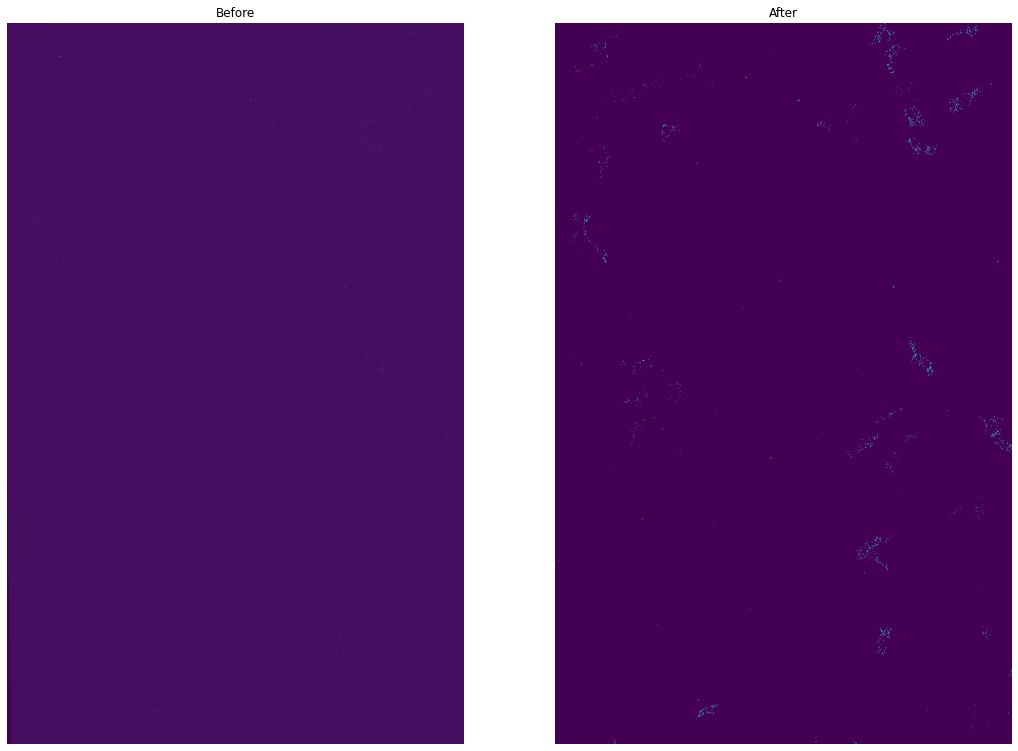

<Figure size 3000x2000 with 0 Axes>

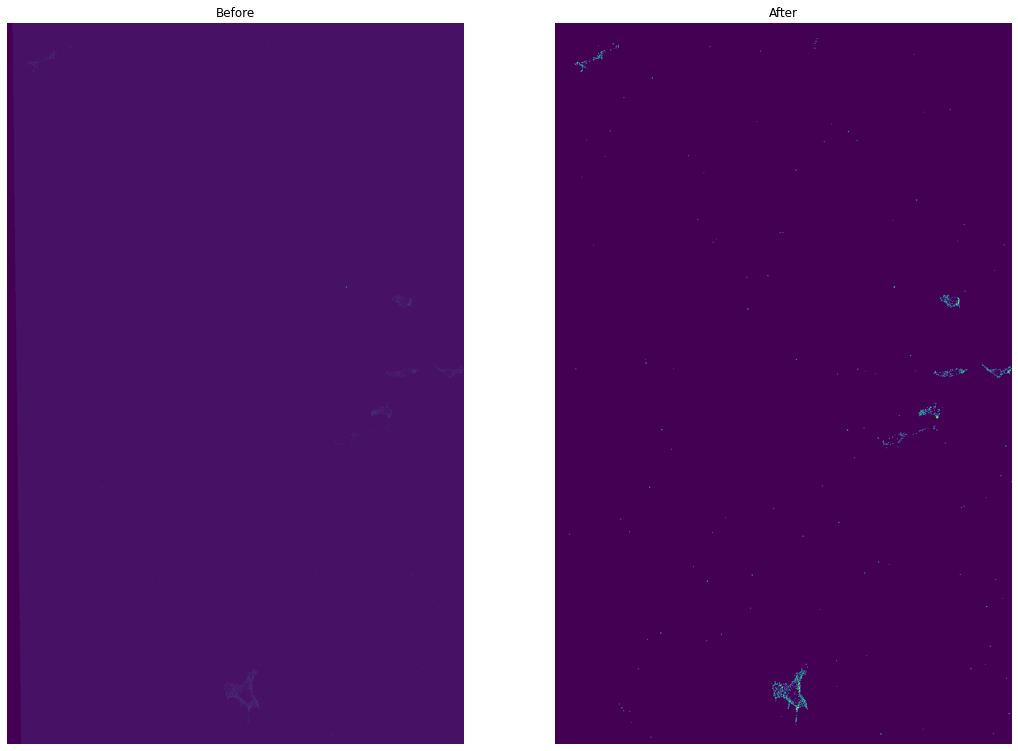

<Figure size 3000x2000 with 0 Axes>

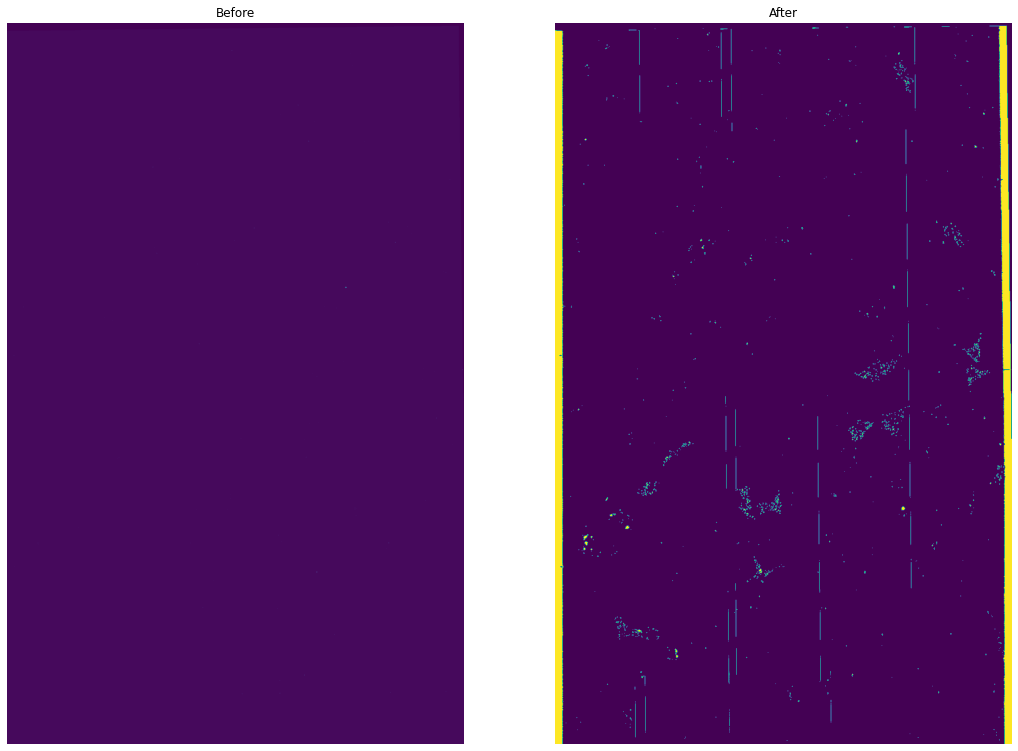

In [25]:
# Using threshold Yen on Xthresh which has been topped and stretched
Xyen = np.zeros(Xthresh.shape)
for i in range(Xthresh.shape[0]):
    image = Xthresh[i, 0]
    thresh = threshold_yen(image)
    binary = image > thresh
    Xyen[i, 0, ] = binary
    
    plt.figure(dpi=500)
    fig, axes = plt.subplots(ncols=2, figsize=(18, 18))
    ax = axes.ravel()

    ax[0].imshow(Xcenter[i, 0])
    ax[0].set_title('Before')

    ax[1].imshow(binary)
    ax[1].set_title('After')

    for a in ax:
        a.axis('off')

    plt.show()

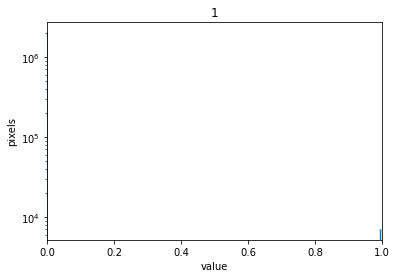

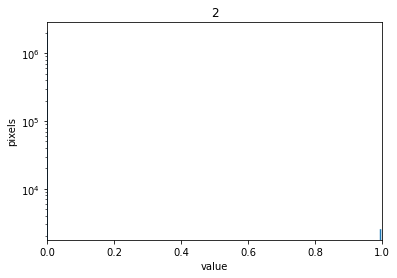

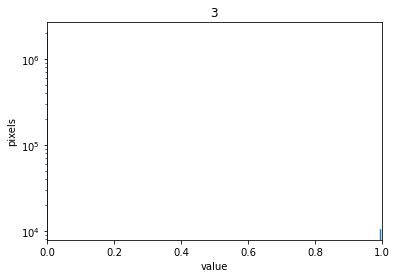

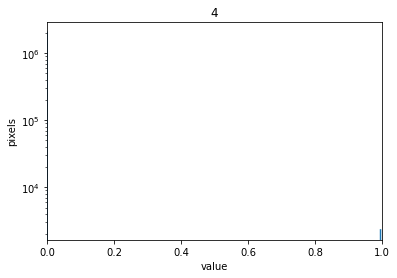

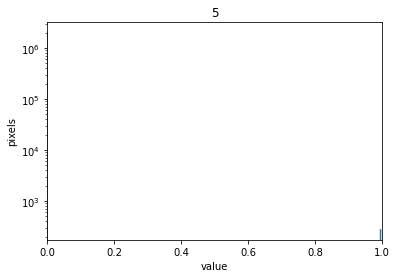

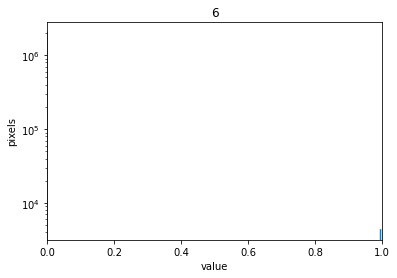

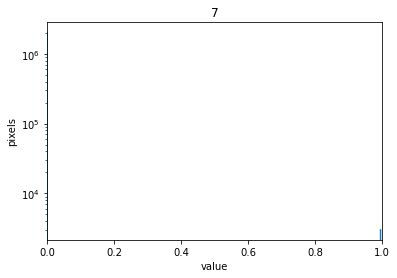

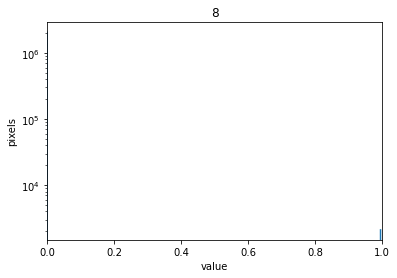

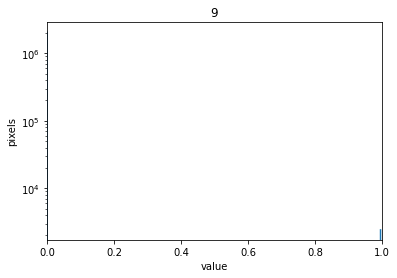

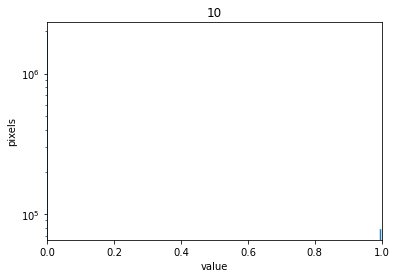

In [68]:
for i in range(Xyen.shape[0]):
    histogram, bin_edges = np.histogram(Xyen[i, 0, ], bins=256, range=(0, 1))

    # configure and draw the histogram figure
    plt.figure()
    plt.title(i+1)
    plt.xlabel("value")
    plt.ylabel("pixels")

    plt.semilogy(bin_edges[0:-1], histogram)  # <- or here

    plt.xlim([0.0, 1.0])  # <- named arguments do not work here
    plt.show()

In [62]:
# # Before and after (partial region)
# # with bardensr.plotting.AnimAcross() as a:
# for i in range(Xthresh.shape[0]):
#     plt.figure(dpi=250)
#     plt.subplot(1, 2, 1)
# #     a('before')
#     plt.imshow(Xnorm[i, 0, 200:500, 200:500])
#     plt.subplot(1, 2, 2)
# #     a('after')
#     plt.imshow(Xthresh[i, 0, 200:500, 200:500])

# Peak calling and counting (inside membrane masks)

**Check by overlay to see if there are enough spots called.**

In [63]:
# Read in the membrane segmentation
with open('./data/20210714masks_mem.npy', 'rb') as m:
    masks_mem = np.load(m)

In [64]:
# plt.figure(dpi=250)
# plt.imshow(masks_mem)
# plt.axis('image')

In [65]:
# Find the number of membrane segmentation masks
# np.unique(masks_mem)

In [66]:
# # Check starting from which number the masks are truly membrane segmentation (instead of the background)
# plt.figure(dpi=300)
# for i in range(0, 5):
#     plt.figure()
#     plt.imshow(np.array(masks_mem)==i)

In [67]:
#     xindex = test.loc[i, 'm2'] + left
#     yindex = test.loc[i, 'm1'] + up

In [68]:
# pd.DataFrame(np.zeros((len(np.unique(masks_mem)), Xthresh.shape[0])))

In [69]:
# # cell_table = pd.DataFrame(np.zeros((len(np.unique(masks_mem)), Xthresh.shape[0])))
# cell_table = np.zeros((len(np.unique(masks_mem)), Xthresh.shape[0]))

# for k in range(Xthresh.shape[0]):  # for the kth image
#     # Get local maximum values of desired neighborhood (size of the amplicons)
#     max_fil = ndimage.maximum_filter(Xthresh[k,], size=(1, 2, 2))

#     # Threshold the image to find locations of interest
#     # assuming 6 standard deviations above the mean of the image
# #     peak_thresh = max_fil.mean() + max_fil.std() * 6
#     peak_thresh = 0.2

#     # find areas greater than peak_thresh
#     labels, num_labels = ndimage.label(max_fil > peak_thresh)

#     # Get the positions of the maxima
#     coords = ndimage.measurements.center_of_mass(Xthresh[k,], 
#                                                  labels=labels, 
#                                                  index=np.arange(1, num_labels + 1))

#     # # Get the maximum value in the labels
#     # values = ndimage.measurements.maximum(img, labels=labels, index=np.arange(1, num_labels + 1))
#     # # https://stackoverflow.com/questions/55453110/how-to-find-local-maxima-of-3d-array-in-python

#     for _, m1, m2 in coords:
#         m1 = int(np.round(m1))
#         m2 = int(np.round(m2))
#         mem_id = masks_mem[m1+up, m2+left]  # important to match the coordinates if images are trimmed
#         if mem_id>0: # 0 is background
# #             cell_table.loc[mem_id, k] += 1
#             cell_table[mem_id, k] += 1

In [70]:
# cell_table = pd.DataFrame(np.zeros((len(np.unique(masks_mem)), Xthresh.shape[0])))
cell_table = np.zeros((len(np.unique(masks_mem)), Xyen.shape[0]))

for k in range(Xyen.shape[0]):  # for the kth image
    # Get local maximum values of desired neighborhood (size of the amplicons)
    max_fil = ndimage.maximum_filter(Xyen[k,], size=(1, 2, 2))

    # Threshold the image to find locations of interest
    # assuming 6 standard deviations above the mean of the image
#     peak_thresh = max_fil.mean() + max_fil.std() * 6
    peak_thresh = 0.2

    # find areas greater than peak_thresh
    labels, num_labels = ndimage.label(max_fil > peak_thresh)

    # Get the positions of the maxima
    coords = ndimage.measurements.center_of_mass(Xyen[k,], 
                                                 labels=labels, 
                                                 index=np.arange(1, num_labels + 1))

    # # Get the maximum value in the labels
    # values = ndimage.measurements.maximum(img, labels=labels, index=np.arange(1, num_labels + 1))
    # # https://stackoverflow.com/questions/55453110/how-to-find-local-maxima-of-3d-array-in-python

    for _, m1, m2 in coords:
        m1 = int(np.round(m1))
        m2 = int(np.round(m2))
        mem_id = masks_mem[m1+up, m2+left]  # important to match the coordinates if images are trimmed
        if mem_id>0: # 0 is background
#             cell_table.loc[mem_id, k] += 1
            cell_table[mem_id, k] += 1

In [71]:
# import DeCRISP as dcp
# cell_table = create_celltable(Xthresh, masks_mem, n_std=6, up_adjust=up, left_adjust=left)
# cell_table

In [72]:
# labels

In [73]:
num_labels

929

In [74]:
coords[:10]

[(0.0, 901.3949499623994, 1125.8324174234974),
 (0.0, 8.0, 974.0),
 (0.0, 9.0, 846.0),
 (0.0, 9.387096774193548, 878.6451612903226),
 (0.0, 10.0, 728.0),
 (0.0, 10.0, 1000.0),
 (0.0, 11.96551724137931, 647.6206896551724),
 (0.0, 55.577777777777776, 897.0),
 (0.0, 13.0, 369.0),
 (0.0, 14.0, 249.0)]

In [75]:
int(np.round(801.5228444869555))

802

In [76]:
len(coords)

929

In [77]:
np.max(cell_table)

125.0

In [78]:
pd.DataFrame(cell_table)

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,5.0,7.0,0.0,0.0,1.0,6.0,9.0,0.0,3.0
3,4.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
4,2.0,1.0,28.0,0.0,0.0,20.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...
331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
# pd.DataFrame(cell_table).to_csv('./result/crisprmap20210714sg2NEB_cell_table.csv')

In [80]:
cell_table.shape

(336, 10)

# Nearest Neighbor/Correlation

In [81]:
# Calculate the correlation
cell_norm = np.sqrt(np.sum(np.power(cell_table, 2), axis=1))
cell_corr = cell_table.dot(codebook.T) / np.reshape(cell_norm + 1e-6, (-1,1))  # add 1e-6 to avoid the denominator being 0

In [82]:
cell_corr

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.999999  ,
        0.        ],
       [0.1407195 , 0.        , 0.77395724, ..., 0.49251825, 0.91467674,
        0.98503649],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [83]:
cell_corr.shape

(336, 10)

In [84]:
# cell_norm + 1e-6

In [85]:
# (cell_table.dot(codebook.T) / np.reshape(cell_norm, (-1,1))).shape

In [86]:
# cell_norm

In [87]:
# np.reshape(cell_norm, (-1,1))

In [88]:
def argmax_thresh(a, axis, thresh):
#     rows = np.where(a == a.max(axis=1)[:, None])[0]
    rows_too_small = np.where(np.max(a, axis=1) < thresh)
    my_argmax = a.argmax(axis=axis)
    my_argmax[rows_too_small] = -1
    return my_argmax
# https://stackoverflow.com/questions/51318081/numpy-argmax-when-values-are-equal

In [111]:
# Assign cells to barcodes according to the max correlation
# cell_id = pd.DataFrame(np.argmax(cell_corr, axis=1), columns=['barcode'])
corr_thresh = 0.01
cell_id = pd.DataFrame(argmax_thresh(cell_corr, axis=1, thresh=corr_thresh), columns=['barcode'])
cell_id

,barcode
0,-1
1,4
2,4
3,0
4,6
...,...
331,-1
332,-1
333,-1
334,-1


In [90]:
# temp = cell_id.copy()
# temp['group'] = np.zeros(temp.shape[0])
# temp.group[temp.barcode.isin([0, 1, 2, 3, 4])] = 'GFP'
# temp.group[temp.barcode>4] = 'NTC'
# temp

In [91]:
# cell_id.loc[200:210]

In [92]:
# cell_id.to_csv('./result/crisprmap20210714sg2NEB_picklemax_cell_id_threshYen_minusone.csv', index=False)

In [93]:
heapq.nlargest(2, cell_corr[116,])

[0.0, 0.0]

In [94]:
def minmax(x, min_all, max_all):
    y = (x-min_all)/max_all
    return y

In [112]:
cell_id['max'] = minmax(np.max(cell_corr, axis=1), min_all=np.min(cell_corr), max_all=np.max(cell_corr))
cell_id['second_max'] = minmax([heapq.nlargest(2, cell_corr[i,])[1] for i in cell_id.index], min_all=np.min(cell_corr), max_all=np.max(cell_corr))
# cell_id['second_max'] = [heapq.nlargest(2, cell_corr[i,])[1] for i in cell_id.index]
cell_id['quality'] = cell_id['max'] - cell_id['second_max']
cell_id['spots_sum'] = np.sum(cell_table, axis=1)
cell_id['spots_max'] = np.max(cell_table, axis=1)
# cell_id = cell_id.sort_values(by=['quality'], ascending=False)
cell_id

,barcode,max,second_max,quality,spots_sum,spots_max
0,-1,0.000000,0.000000,0.000000,0.0,0.0
1,4,0.707106,0.707106,0.000000,1.0,1.0
2,4,0.796030,0.696526,0.099504,32.0,9.0
3,0,0.989949,0.565685,0.424264,7.0,4.0
4,6,0.982666,0.573222,0.409444,53.0,28.0
...,...,...,...,...,...,...
331,-1,0.000000,0.000000,0.000000,0.0,0.0
332,-1,0.000000,0.000000,0.000000,0.0,0.0
333,-1,0.000000,0.000000,0.000000,0.0,0.0
334,-1,0.000000,0.000000,0.000000,0.0,0.0


In [96]:
# cell_id.head(40)

In [97]:
np.sum(cell_table, axis=1).shape

(336,)

In [98]:
cell_id.sort_values(by=['spots'], ascending=False).head(20)

,barcode,max,second_max,quality,spots
24,8,0.995516,0.544959,0.450557,249.0
206,7,0.990796,0.605747,0.385049,242.0
216,0,0.993653,0.531091,0.462563,200.0
165,8,0.978836,0.603963,0.374873,149.0
191,8,0.966346,0.654376,0.311970,144.0
227,9,0.998278,0.528938,0.469340,143.0
281,8,0.994007,0.575893,0.418114,138.0
271,8,0.985728,0.558579,0.427149,130.0
99,8,0.987254,0.511256,0.475997,129.0
196,4,0.902007,0.612474,0.289533,116.0


In [99]:
cell_id.sort_values(by=['quality'], ascending=False).head(20)

,barcode,max,second_max,quality,spots
256,3,0.999999,0.000000,0.999999,2.0
188,1,0.999999,0.000000,0.999999,2.0
209,3,0.977176,0.000000,0.977176,23.0
193,3,0.988483,0.061780,0.926703,36.0
151,3,0.953632,0.029801,0.923831,33.0
163,1,0.988851,0.070632,0.918219,48.0
290,1,0.993735,0.077434,0.916301,84.0
185,1,0.991837,0.090167,0.901670,48.0
174,3,0.894427,0.000000,0.894427,4.0
162,1,0.987457,0.133440,0.854017,44.0


<AxesSubplot:xlabel='quality', ylabel='Count'>

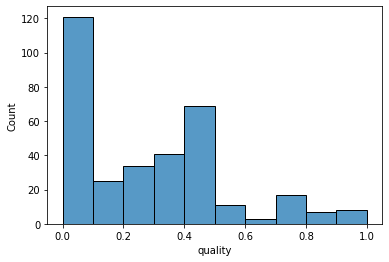

In [100]:
import seaborn as sns
sns.histplot(data=cell_id, x="quality")

<AxesSubplot:xlabel='max', ylabel='Count'>

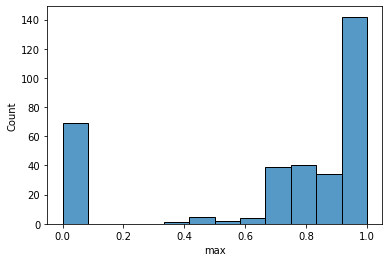

In [101]:
import seaborn as sns
sns.histplot(data=cell_id, x="max")

<AxesSubplot:xlabel='second_max', ylabel='Count'>

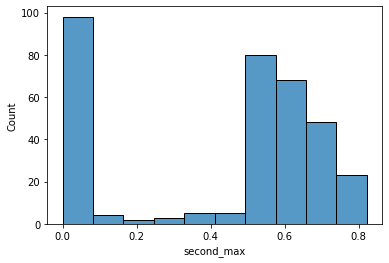

In [102]:
import seaborn as sns
sns.histplot(data=cell_id, x="second_max")

In [103]:
cell_id[cell_id['quality']>0.7]

,barcode,max,second_max,quality,spots
12,3,0.707106,0.000000,0.707106,1.0
17,3,0.707106,0.000000,0.707106,1.0
50,3,0.707106,0.000000,0.707106,1.0
87,3,0.707106,0.000000,0.707106,1.0
107,3,0.707106,0.000000,0.707106,1.0
122,3,0.707106,0.000000,0.707106,1.0
139,3,0.707106,0.000000,0.707106,1.0
140,3,0.813733,0.000000,0.813733,7.0
151,3,0.953632,0.029801,0.923831,33.0
161,3,0.854177,0.062122,0.792055,63.0


In [104]:
# # Possibly plot which cells have high quality scores
# high_quality = cell_id[cell_id['quality']>0.7]
# high_quality_mem = np.zeros(masks_mem.shape)
# for i in high_quality.index:
#     high_quality_mem[np.array(masks_mem)==i] = i
# plt.figure(dpi=250)
# plt.imshow(high_quality_mem)

In [105]:
# sns.histplot(data=cell_id, x="max")

In [106]:
# set(cell_id['max'])

In [107]:
np.max(cell_corr)

1.41421347146401

In [108]:
cell_corr.shape

(336, 10)

[(0.0, 250.0)]

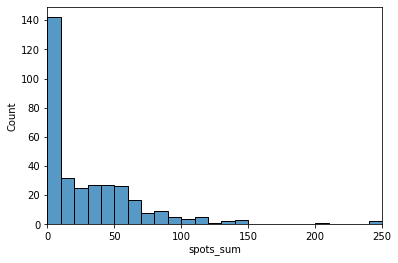

In [119]:
sh = sns.histplot(data=cell_id, x="spots_sum", binwidth=10)
sh.set(xlim=(0, 250))

[(0.0, 250.0)]

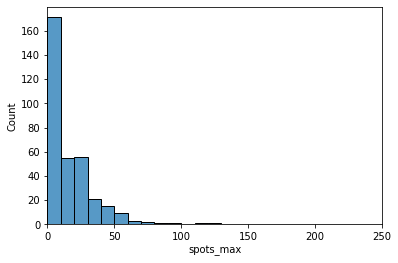

In [120]:
sh = sns.histplot(data=cell_id, x="spots_max", binwidth=10)
sh.set(xlim=(0, 250))

In [110]:
np.median(cell_id.spots)

18.0

<!-- list1 = [10, 20, 4, 45, 99]
 
# new_list is a set of list1
new_list = set(list1)
 
# removing the largest element from temp list
new_list.remove(max(new_list))
 
# elements in original list are not changed
# print(list1)
 
print(max(new_list)) -->